In [ ]:
# INF2178 - Assignment4
# Student Name: Jingxian Chen
# Student Number: 1005354572
# Creation Date: Apirl 1, 2024

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower

In [3]:
# Load the dataset
data = pd.read_csv('INF2178_A4_data.csv')
data

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,366,OAS2_0184,OAS2_0184_MR2,Demented,2,553,F,R,73,16,3.0,21.0,1.0,1351,0.708,1.299
290,367,OAS2_0185,OAS2_0185_MR1,Demented,1,0,M,R,80,16,1.0,28.0,0.5,1704,0.711,1.030
291,368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
292,370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331


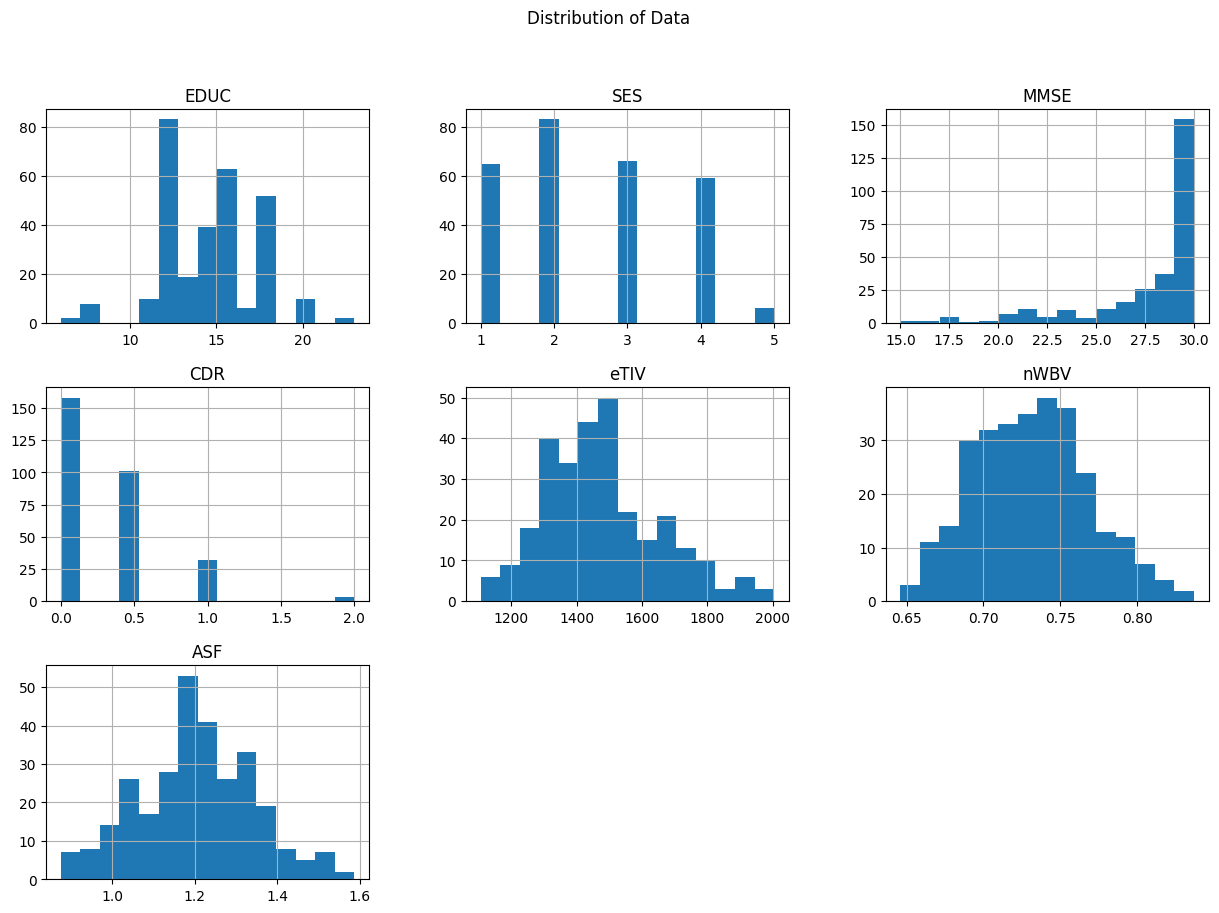

In [4]:
# General EDA for scores

# Distribution plots for scores
data[['EDUC','SES','MMSE','CDR','eTIV','nWBV','ASF']].hist(bins=15,figsize=(15,10))
plt.suptitle('Distribution of Data')
plt.show()

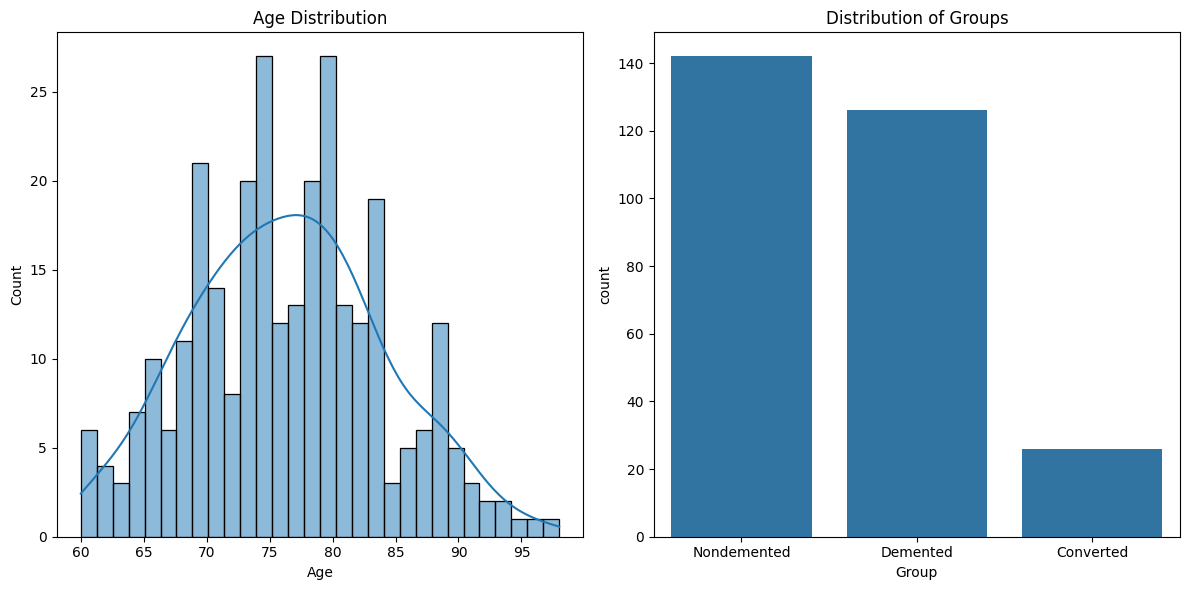

In [5]:
# EDA: Check the distribution of age and group classification
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['Age'], kde=True, bins=30)
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='Group', data=data)
plt.title('Distribution of Groups')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age Distribution by Group')

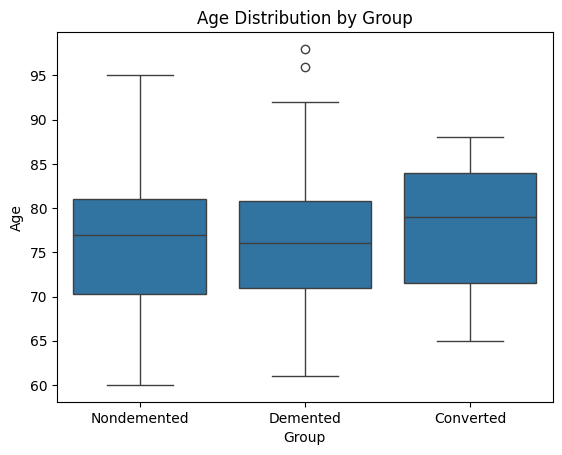

In [6]:
# Boxplot of Age Distribution by Group
sns.boxplot(x='Group', y='Age', data=data)
plt.title('Age Distribution by Group')

Text(0.5, 1.0, 'MMSE Scores by Group')

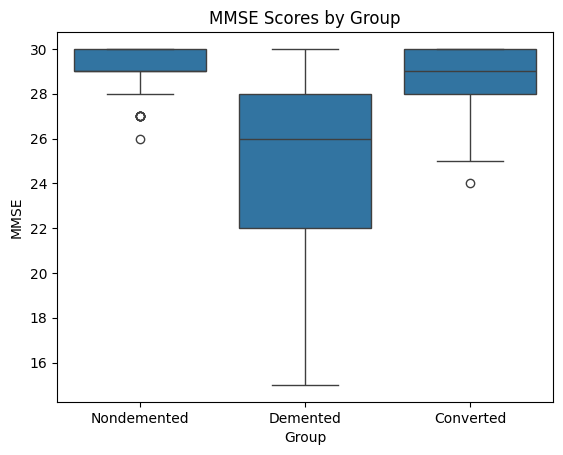

In [7]:
# Boxplot of MMSE Scores by Group
sns.boxplot(x='Group', y='MMSE', data=data)
plt.title('MMSE Scores by Group')

In [9]:
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.2 MB/s eta 0:00:00


In [10]:
# Prepare data for mixed-effects model
data['Group_code'] = data['Group'].astype('category').cat.codes
data['Subject_ID_code'] = data['Subject ID'].astype('category').cat.codes


# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='nWBV', within='Visit', between='Group_code', subject='Subject_ID_code', data=data)

# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
Group_code   0.034      2    141  0.017   6.712    0.002  0.087  nan
Visit        0.007      1    141  0.007  94.251    0.000  0.401    1.000
Interaction  0.000      2    141  0.000   1.534    0.219  0.021  nan



In [20]:
# Checking assumptions

# Mauchly's test of spericity
pg.sphericity(data=data, dv='nWBV', subject='Subject_ID_code', within='Visit')[-1]


1.0

In [18]:
# Test of normality
pg.normality(data=data, dv='nWBV', group='Visit')

,W,pval,normal
Visit,,,
1,0.990075,0.372060,True
2,0.989654,0.366703,True


In [ ]:
# Post-hoc Test
posthocs = pg.pairwise_ttests(dv='nWBV', within='Visit', between='Group',
                              subject='Subject_ID_code', data=data)
pg.print_table(posthocs)

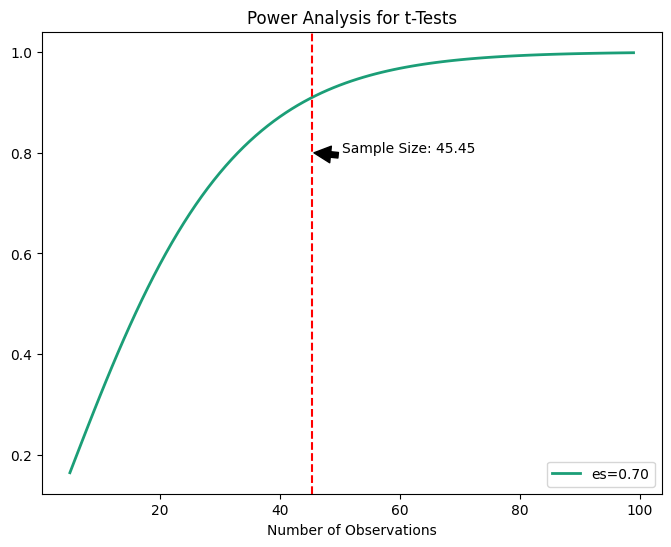

In [21]:
# Power analysis for t-tests
effect_size = 0.7  # Assume large effect size
alpha = 0.05  # Significance level
power = 0.91  # Desired power

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1.0)

fig, ax = plt.subplots(figsize=(8, 6))
power_analysis.plot_power(dep_var='nobs',
                          nobs=np.array(range(5, 100)),
                          effect_size=np.array([effect_size]),
                          alpha=alpha,
                          ax=ax)
plt.axvline(x=sample_size, color='red', linestyle='--')
ax.annotate(f'Sample Size: {sample_size:.2f}', xy=(sample_size, 0.8), xytext=(sample_size+5, 0.8),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Power Analysis for t-Tests')
plt.show()
